# Deep learning model using lstms after embedding

In [35]:
#can be removed
from jupyterthemes import jtplot
jtplot.style()

First, let's load the data

In [2]:
import pandas as pd

In [6]:
df = pd.read_csv("../data/cleaned_data.csv")
df

,text,subreddit,label
0,that sounds awesome i ll check it out tonight ...,startrek,television
1,star trek tos 50th anniversary tribute game n...,startrek,television
2,would nt spock have found it a bit insulting ...,startrek,television
3,spock was half human and had worked for some t...,startrek,television
4,i got a notice from audible this afternoon tha...,startrek,television
...,...,...,...
28740,regular model https wikiteamfortresscomwim...,tf2,gaming
28741,my friend gave me a strange killstreak version...,tf2,gaming
28742,so i m pretty sad to know that the bottle does...,tf2,gaming
28743,fun fact if you die with the neon annihilator...,tf2,gaming


In [19]:
data = df["text"].values
y_data = pd.get_dummies(df["label"],prefix='cat').values

## Specific preprocessing

1. construct dictionary
2. replace tokens in sequences with keys from dictionary
3. pad the sequences

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

W1201 20:23:46.922636 140075216189120 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [9]:
from nltk.util import ngrams
from collections import defaultdict
from os import linesep

def build_voc(corpus):
    
    word_dict = {}

    for document in corpus:
        for word in document:
            if word not in word_dict:
                word_dict[word] = len(word_dict) + 1 # 0 = padding
                
    with open("./vocab.txt", "w") as f:
        for word in word_dict.keys():
            f.write(word + "\n")
        
    return word_dict

In [10]:
def split_items(list_of_strings):
    stripped_strings = []
    for string in list_of_strings:
        stripped_strings.append(string.split(' '))
    return stripped_strings

In [11]:
splited_data = split_items(data)

In [12]:
vocab = build_voc(splited_data)

In [14]:
vocab_size = len(vocab)
vocab_size

54629

In [15]:
def get_max_sentence_length(corpus):
    return max([len(sentence) for sentence in corpus])

In [16]:
def get_number_vectors(X):
    
    return [[vocab[word] for word in sentence] for sentence in X]

In [17]:
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences

max_sentence_length = get_max_sentence_length(splited_data)
print("max sentence length: ", max_sentence_length)

def get_padded_sequences(X):
    return pad_sequences(sequences=get_number_vectors(X),
                         padding='post',
                         maxlen=max_sentence_length)

def get_padded_sequences_max(X, max_len):
    return pad_sequences(sequences=get_number_vectors(X),
                         padding='post',
                         maxlen=max_len)

padded_data = get_padded_sequences(splited_data)

Using TensorFlow backend.


max sentence length:  10000


In [18]:
# fix max length of sequences
padded_data = get_padded_sequences_max(splited_data, 100)

In [42]:
padded_data

array([[   1,    2,    3, ...,    0,    0,    0],
       [  13,   17,   80, ...,   85,  124,   17],
       [ 125,  126,  127, ...,    0,    0,    0],
       ...,
       [  14,    4,  166, ...,    0,    0,    0],
       [ 276,  853,   17, ...,    0,    0,    0],
       [ 171, 5259, 1900, ...,    0,    0,    0]], dtype=int32)

## Split data into train, validation and test sets

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_data, y_data, test_size=0.3, random_state=32)
partial_x_train, x_validation, partial_y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=32)

## NN model

In [91]:

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size + 1, 32))
#model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.LSTM(32, return_sequences=True))
#model.add(keras.layers.LSTM(32, return_sequences=True))
#model.add(keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.LSTM(32))
#model.add(keras.layers.Dense(8, activation=tf.nn.relu))
model.add(keras.layers.Dense(7, activation=tf.nn.sigmoid))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 32)          1748160   
_________________________________________________________________
lstm_33 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
lstm_34 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_28 (Dense)             (None, 7)                 231       
Total params: 1,765,031
Trainable params: 1,765,031
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=30,
                   batch_size=1024,
                   validation_data=(x_validation, y_validation),
                   verbose=1)

Train on 14084 samples, validate on 6037 samples
Epoch 1/30
14084/14084 [==============================] - 9s 639us/sample - loss: 1.9334 - acc: 0.2341 - val_loss: 1.9115 - val_acc: 0.2281
Epoch 2/30
14084/14084 [==============================] - 5s 335us/sample - loss: 1.8885 - acc: 0.2336 - val_loss: 1.8764 - val_acc: 0.2281
Epoch 3/30
14084/14084 [==============================] - 5s 331us/sample - loss: 1.8731 - acc: 0.2336 - val_loss: 1.8707 - val_acc: 0.2281
Epoch 4/30
14084/14084 [==============================] - 5s 335us/sample - loss: 1.8700 - acc: 0.2336 - val_loss: 1.8694 - val_acc: 0.2281
Epoch 5/30
14084/14084 [==============================] - 5s 332us/sample - loss: 1.8686 - acc: 0.2336 - val_loss: 1.8687 - val_acc: 0.2281
Epoch 6/30
14084/14084 [==============================] - 5s 325us/sample - loss: 1.8670 - acc: 0.2336 - val_loss: 1.8678 - val_acc: 0.2281
Epoch 7/30
14084/14084 [==============================] - 5s 331us/sample - loss: 1.8643 - acc: 0.2336 - val_lo

In [93]:
results = model.evaluate(X_test, y_test)
print(results)

8624/8624 [==============================] - 7s 853us/sample - loss: 1.6489 - acc: 0.3971
[1.6489155248277483, 0.3971475]


## Visualize accuracy and loss on epochs

In [79]:
history_dict = history.history
history_dict.keys()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc)+1)

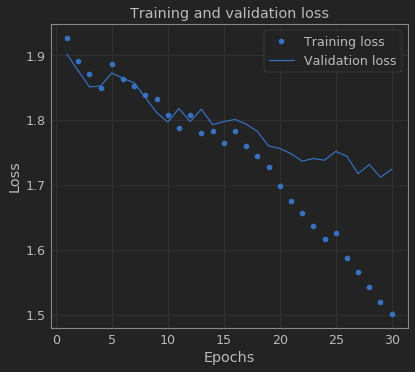

In [80]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

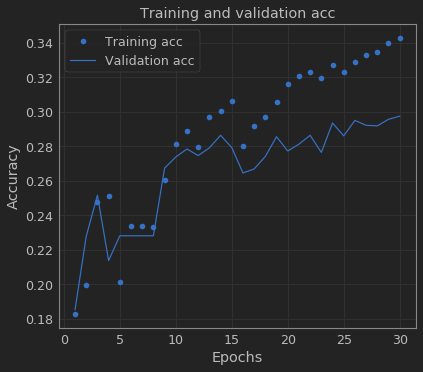

In [81]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()